# Striplog expert functions

This notebooks looks at the main `striplog` object. For the basic objects it depends on, see [Basic objects](./Basic_objects.ipynb).

First, import anything we might need.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.8.4'

In [2]:
from striplog import Legend, Lexicon, Interval, Component

In [3]:
legend = Legend.builtin('NSDOE')
lexicon = Lexicon.default()

----

## Making a `striplog` from a PNG

In [4]:
from striplog import Striplog
imgfile = "M-MG-70_14.3_135.9.png"

In [5]:
strip = Striplog.from_img(imgfile, 14.3, 135.9, legend=legend)
strip

/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/striplog/striplog.py:868: UserWarning: from_img() is deprecated; please use from_image()
  warnings.warn(w)


Striplog(26 Intervals, start=14.3, stop=135.9)

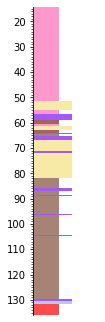

In [6]:
strip.plot(legend, ladder=True, aspect=3)

----
## Making, finding and annealing gaps

This striplog doesn't have any gaps...

In [7]:
strip.find_gaps() or "No gaps!"

'No gaps!'

But we can make some by deleting indices:

In [8]:
del strip[[2, 7, 12]]
strip.find_gaps()

Striplog(3 Intervals, start=54.81764705882354, stop=71.80588235294118)

We can also get a list of the indices of intervals that are followed by gaps (i.e. are directly above gaps in 'depth' order, or directly below gaps in 'elevation' order).

In [9]:
strip.find_gaps(index=True)

[1, 5, 9]

In [10]:
strip.thinnest()

Interval({'top': Position({'middle': 95.9, 'units': 'm'}), 'base': Position({'middle': 96.2764705882353, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'dolomite'})]})

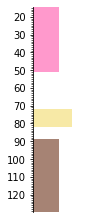

In [11]:
strip.thickest(n=5).plot(legend=legend, aspect=2)

In [12]:
strip

Striplog(23 Intervals, start=14.3, stop=135.9)

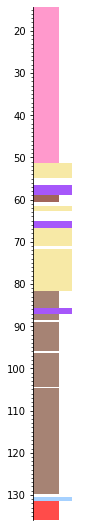

In [13]:
strip = strip.prune(limit=1)
strip.plot(legend=legend, aspect=5)

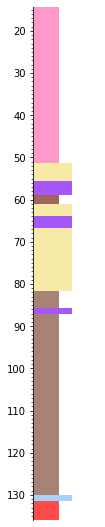

In [14]:
strip = strip.anneal()
strip.plot(legend=legend, aspect=5)

In [15]:
strip.find_gaps() or "No gaps!"

'No gaps!'

## Label the intervals

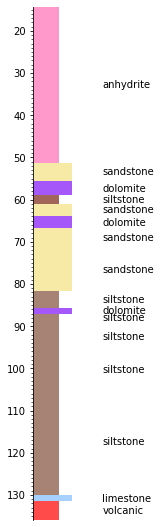

In [16]:
strip.plot(label='lithology', legend=legend, aspect=5)

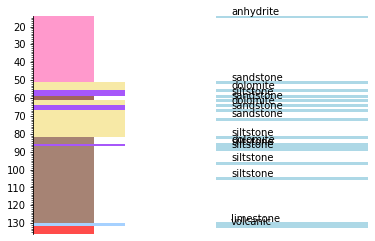

In [17]:
fig, axs = plt.subplots(ncols=2, sharey=True)
axs[0] = strip.plot(ax=axs[0], legend=legend)
axs[1] = strip.plot_tops(axs[1], field='lithology', )
axs[1].axis('off')
plt.show()

In [18]:
strip[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]})

In [19]:
round(3.1415936, 2)

3.14

In [20]:
import random

for iv in strip:
    iv.data['por'] = round(random.random() / 4, 3)
    
strip[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {'por': 0.011}, 'components': [Component({'lithology': 'anhydrite'})]})

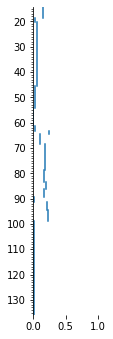

In [21]:
strip.plot(style='field', field='por', aspect=3)

In [22]:
strip[0].middle

32.77058823529412

In [23]:
strip[0].primary['lithology']

'anhydrite'

### Other types of anneal

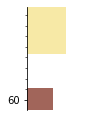

In [24]:
s = strip[[1, 3]]
s.plot(legend=legend, aspect=1)

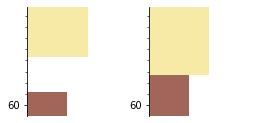

In [25]:
# Default behaviour: meet in middle.
fig, axs = plt.subplots(ncols=2, figsize=(4,2))
s.plot(legend=legend, aspect=1, ax=axs[0])
s.anneal(mode='middle').plot(legend=legend, ax=axs[1])
plt.show()

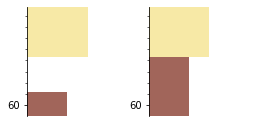

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(4,2))
s.plot(legend=legend, aspect=1, ax=axs[0])
s.anneal(mode='up').plot(legend=legend, ax=axs[1])
plt.show()

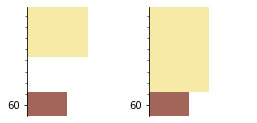

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(4,2))
s.plot(legend=legend, aspect=1, ax=axs[0])
s.anneal(mode='down').plot(legend=legend, ax=axs[1])
plt.show()

----
## Overlapping intervals

If there are overlapping intervals in a striplog, you can find them with `find_overlaps()`. 

In [28]:
lappy = Striplog([Interval(**{'top': 50, 'base': 60, 'components':[Component({'lithology': 'dolomite'}),]}),
                  Interval(**{'top': 55, 'base': 75, 'components':[Component({'lithology': 'limestone'}),]}),
                  Interval(**{'top': 75, 'base': 80, 'components':[Component({'lithology': 'volcanic'}),]}), 
                  Interval(**{'top': 78, 'base': 90, 'components':[Component({'lithology': 'anhydrite'}),]})
                  ])

In [29]:
lappy.find_overlaps(index=True)

[0, 2]

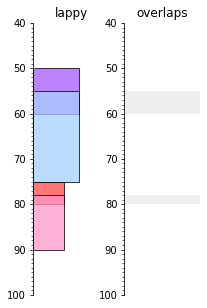

In [30]:
overlaps = lappy.find_overlaps()

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(3,5))

# Use alpha to highlight overlaps.
ax0 = lappy.plot(legend, ax=ax0, alpha=0.75, lw=1)
ax1 = overlaps.plot(ax=ax1)

ax0.set_title('lappy')
ax1.set_title('overlaps')

ax0.set_ylim(100, 40)

plt.show()

The `merge_overlaps()` method operates in place and returns nothing.

In [31]:
lappy.merge_overlaps()

Now there are no overlaps!

In [32]:
lappy.find_overlaps()

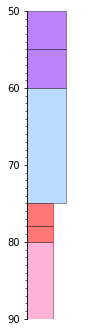

In [33]:
lappy.plot(legend, aspect=3, alpha=0.75, ec='k', lw=0.5)

The merged intervals have mixed components:

In [34]:
lappy[1].components

[Component({'lithology': 'dolomite'}), Component({'lithology': 'limestone'})]

Note that the description is rather garbled.

In [35]:
lappy[1].description

'66.7% 20.00 m of limestone with 33.3% 10.00 m of dolomite'

## Merge

New way to merge. Uses precendence to decide what to take in each merge zone. 

**Note, does not combine the components in a merge zone. You have to choose one or the other.**

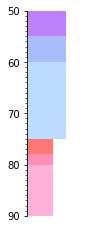

In [36]:
lappy = Striplog([Interval(**{'top': 50, 'base': 60, 'components':[Component({'lithology': 'dolomite'}),]}),
                  Interval(**{'top': 55, 'base': 75, 'components':[Component({'lithology': 'limestone'}),]}),
                  Interval(**{'top': 75, 'base': 80, 'components':[Component({'lithology': 'volcanic'}),]}), 
                  Interval(**{'top': 78, 'base': 90, 'components':[Component({'lithology': 'anhydrite'}),]})
                  ])

lappy.plot(legend, aspect=2, alpha=0.75)

You have to provide an `Interval` attribute (like 'top', 'base', or 'thickness') **or** a component attribute to merge on (if you use a component attribute, `merge` gets this attribute from the primary component to decide what to keep in each zone). The attribute must suport ordering &mdash; `striplog` keeps the thing with the larger value (or the thing which comes last in the ordering), e.g. the thickest, deepest, etc. If you want the reverse behaviour (keep the thinnest, shallowest, etc, then pass the `reverse=True`.

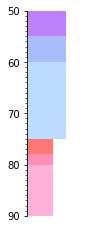

In [37]:
lappy.plot(legend, aspect=2, alpha=0.75)

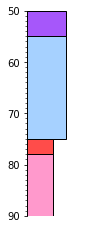

In [38]:
lappy.merge('top').plot(legend, aspect=2, lw=1)

In [39]:
lappy.merge('top')[0].base.z

55.0

In [40]:
lappy.merge('top', reverse=True)[0].base.z

60.0

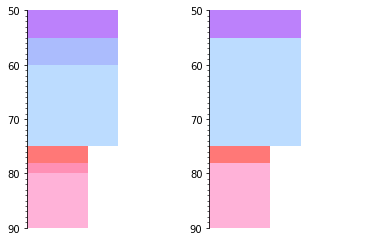

In [41]:
fig, axs = plt.subplots(ncols=2)
lappy.plot(legend, aspect=2, alpha=0.75, ax=axs[0])
lappy.merge('top').plot(legend, aspect=2, alpha=0.75, ax=axs[1])
plt.show()

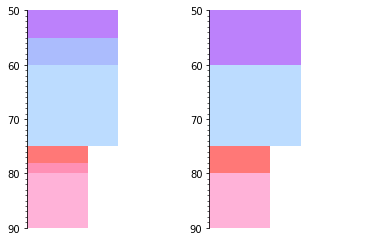

In [42]:
fig, axs = plt.subplots(ncols=2)
lappy.plot(legend, aspect=2, alpha=0.75, ax=axs[0])
lappy.merge('top', reverse=True).plot(legend, aspect=2, alpha=0.75, ax=axs[1])
plt.show()

It is not currently possible to blend or combine units in the merge zones; you have to choose one.

----
## Querying the striplog

This results in a new Striplog, contianing only the intervals requested.

In [43]:
strip.find('sandstone')

Striplog(4 Intervals, start=51.24117647058824, stop=81.78235294117647)

In [44]:
strip.find('sandstone').unique

[(Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'}),
  22.423529411764697)]

In [45]:
strip.find('sandstone').cum

22.423529411764697

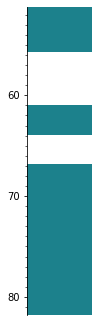

In [46]:
strip.find('sandstone').plot(aspect=3)

Let's ask for the rock we just found by seaching.

In [47]:
rock = strip.find('sandstone')[1].components[0]
rock

lithology,sandstone
colour,grey
grainsize,vf-f


We can also search for a rock...

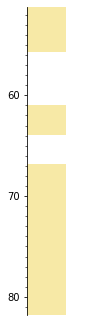

In [48]:
strip.find(rock).plot(legend, aspect=3)

In [49]:
rock in strip

True

And we can ask what is at a particular depth.

In [50]:
strip.read_at(90).primary

lithology,siltstone
colour,grey


----
## Combining striplogs with binary operations

We'd like to operate on the pairs of striplogs, finding overlaps and their intersections.

In [51]:
chrono = Striplog([Interval(**{'top': 0,  'base': 60, 'components':[Component({'age': 'Holocene'})]}),
                   Interval(**{'top': 60, 'base': 75, 'components':[Component({'age': 'Palaeogene'})]}),
                   Interval(**{'top': 75, 'base': 100, 'components':[Component({'age': 'Cretaceous'})]}), 
                   ])

In [52]:
time = Legend.default_timescale()

In [53]:
time[2]

Decor({'_colour': '#fef691', 'width': None, 'component': Component({'age': 'quaternary'}), 'hatch': None})

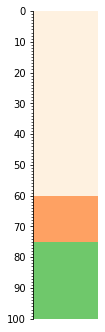

In [54]:
chrono.plot(time, aspect=3)

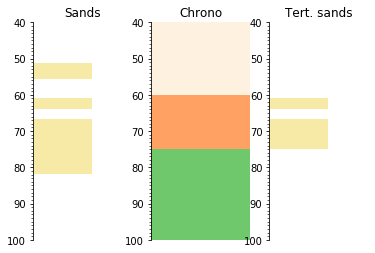

In [55]:
sands = strip.find('sandstone')
cretaceous = chrono.find('Palaeogene')

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)
ax0 = sands.plot(legend, ax=ax0)
ax1 = chrono.plot(time, ax=ax1)
ax2 = sands.intersect(cretaceous).plot(legend, ax=ax2)

ax0.set_title('Sands')
ax1.set_title('Chrono')
ax2.set_title('Tert. sands')

ax0.set_ylim(100, 40)

plt.show()

In [56]:
for i in sands:
    a = chrono.read_at(i.top.z)
    i.data = {'age': a.primary['age']}

In [57]:
sands[1]

Interval({'top': Position({'middle': 60.95882352941177, 'units': 'm'}), 'base': Position({'middle': 63.92352941176471, 'units': 'm'}), 'description': '', 'data': {'age': 'Palaeogene'}, 'components': [Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'})]})

----
## Map, reduce, filter

Striplogs are just lists of `Intervals`, so you can use Python's functional programming patterns on them quite easily. For example, you can map functions and lambdas onto striplogs:

In [58]:
tops_in_feet = map(lambda i: i.top.z/0.3048, strip)
list(tops_in_feet)[:5]  # First 5 only

[46.91601049868766,
 168.11409603211365,
 182.70418403581905,
 193.12567546703724,
 199.9961401883588]

Don't forget the humble list comprehension though...

In [59]:
[i.thickness for i in strip][:5]

[36.941176470588246,
 4.44705882352941,
 3.176470588235297,
 2.094117647058816,
 2.964705882352945]

Add all the thicknesses of intervals with a top depth > 100 m:

In [60]:
from functools import reduce

def sumr(a, b): return a + b

reduce(sumr, [i.thickness for i in strip if i.top.z > 100])

31.341176470588238

To go even further, let's add a porosity array to each interval's primary component:

In [61]:
import random
for iv in strip:
    iv.data['porosity'] = np.random.random(3)/4
strip[4]

Interval({'top': Position({'middle': 60.95882352941177, 'units': 'm'}), 'base': Position({'middle': 63.92352941176471, 'units': 'm'}), 'description': '', 'data': {'por': 0.165, 'porosity': array([0.04986906, 0.1961443 , 0.0098945 ])}, 'components': [Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'})]})

We can also write a function that returns `True` for some condition, and then `filter` intervals on that condition:

In [62]:
def porous(component):
    return component.data['porosity'].mean() > 0.15
    
Striplog(list(filter(porous, strip)))

Striplog(5 Intervals, start=14.3, stop=96.08823529411765)

It's a bit clunky now that `filter` returns an iterator. But it's also clunky because you can't pass arguments to the function you're giving `filter` — so you can't set the porosity to compare against when you call it, you have to edit the function itself.

To pass another argument to the filter function, you'll have to use a closure:

In [63]:
def min_porosity(x):
    def compare(component):
        return component.data['porosity'].mean() > x
    return compare

Striplog(list(filter(min_porosity(0.15), strip)))

Striplog(5 Intervals, start=14.3, stop=96.08823529411765)

<hr />

## Logs from striplogs

The default behaviour is to assign the integer values in order of abundance of each primary component, starting with 1, and leaving 0 for 'unassigned'.

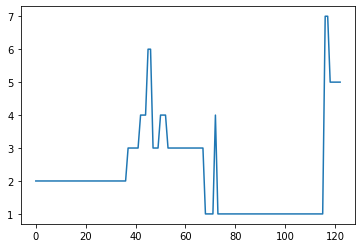

In [64]:
liths = strip.to_log()
plt.plot(liths)
plt.show()

Pass a legend to get the ordering from the legend ('1' is given to the first component in the legend, '2' to the next, and so on).

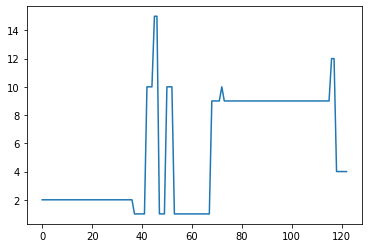

In [65]:
liths = strip.to_log(legend=legend)
plt.plot(liths)
plt.show()

Recall that we added porosity to the components in this striplog:

In [66]:
strip[4]

Interval({'top': Position({'middle': 60.95882352941177, 'units': 'm'}), 'base': Position({'middle': 63.92352941176471, 'units': 'm'}), 'description': '', 'data': {'por': 0.165, 'porosity': array([0.04986906, 0.1961443 , 0.0098945 ])}, 'components': [Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'})]})

In [67]:
# I have broken this.
# por = strip.to_log(field='porosity', field_function=np.mean)
# plt.plot(por)
# plt.show()

We can also export any value corresponding to components from the legend, for example a 'width' log:

In [68]:
w, z, table = strip.to_log(legend=legend, legend_field='width', return_meta=True, step=0.1)
w

array([2., 2., 2., ..., 2., 2., 2.])

...and we can make a composite plot in `matplotlib`:

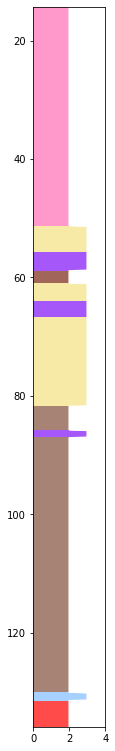

In [69]:
width = 3

fig = plt.figure(figsize=(1,10))
ax = fig.add_axes([0, 0, 1, 1])
ax = strip.plot_axis(ax, legend, default_width=width+1)

plt.plot(w, z, color='white')
plt.fill_betweenx(z, w, width+1, edgecolor='white', facecolor='white', zorder=2)

ax.set_xlim([0, width+1])
ax.set_ylim([strip.stop.z, strip.start.z])
plt.show()

----
## Filtering an array with a striplog

I'd like to 'extract' the data from a log, only where there are intervals. Since we already have ways to filter the striplog to zones of interest (e.g. with `find()` or `filter`) it would be easy to, say, get the GR curve where the striplog indicates sandstone.

In [70]:
import lasio
l = lasio.read("P-129_out.LAS")
z, gr = l['DEPT'], l['GR']

Found nonstandard LAS section: ~Parameter


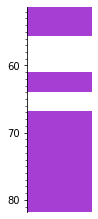

In [71]:
strip.find('sandstone').plot(aspect=2)  # There are actually 4 intervals here; 2 are touching

In [72]:
sand = strip.find('sandstone').to_flag(basis=z)
gr[sand].mean()

70.63407979326

Which is just a convenience; it does the same as:

In [73]:
sand = strip.find('sandstone').to_log(basis=z).astype(bool)
gr[sand].mean()

70.63407979326

Do we need to make this easier? 

<hr />

## Reversing a striplog

You can transform a striplog from 'depth' order to 'elevation' order. 

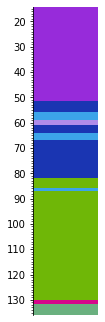

In [74]:
strip.plot(aspect=3)

In [75]:
strip[-1]

Interval({'top': Position({'middle': 131.47647058823532, 'units': 'm'}), 'base': Position({'middle': 135.9, 'units': 'm'}), 'description': '', 'data': {'por': 0.147, 'porosity': array([0.11879512, 0.06608289, 0.15499969])}, 'components': [Component({'lithology': 'volcanic'})]})

In [76]:
s3 = strip.invert(copy=True)

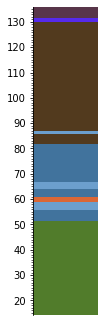

In [77]:
s3.plot(aspect=3)

In [78]:
s3[0]

Interval({'top': Position({'middle': 135.9, 'units': 'm'}), 'base': Position({'middle': 131.47647058823532, 'units': 'm'}), 'description': '', 'data': {'por': 0.147, 'porosity': array([0.11879512, 0.06608289, 0.15499969])}, 'components': [Component({'lithology': 'volcanic'})]})

----
## Outcrop

Tell the CSV loader the columns:

1. base
1. top
1. description

In [79]:
l = """base,top,description
101,120,Till
100,101,Gypsum
50,100,Limestone Formation
28,50,Shale Formation
13,28,Granite Wash
0,13,Basement"""

In [80]:
log = Striplog.from_csv(text=l, lexicon=Lexicon.default())

In [81]:
log.read_at(30)

Interval({'top': Position({'middle': 50.0, 'units': 'm'}), 'base': Position({'middle': 28.0, 'units': 'm'}), 'description': 'Shale Formation', 'data': {}, 'components': [Component({'lithology': 'shale'})]})

In [82]:
log.order

'elevation'

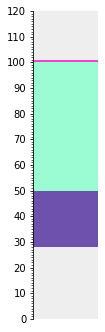

In [83]:
log.plot(aspect=3)

----
## Handling tops

I recommend treating tops as intervals, not as point data.

In [84]:
tops_csv = """top,formation
100, Escanilla Fm.
200, Sobrarbe Fm. 
350, San Vicente Fm.
500, Cretaceous
"""

In [85]:
tops = Striplog.from_csv(text=tops_csv)

In [86]:
print(tops)

{'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 200.0, 'units': 'm'}), 'description': '', 'data': {'formation': 'Escanilla Fm.'}, 'components': []}
{'top': Position({'middle': 200.0, 'units': 'm'}), 'base': Position({'middle': 350.0, 'units': 'm'}), 'description': '', 'data': {'formation': 'Sobrarbe Fm.'}, 'components': []}
{'top': Position({'middle': 350.0, 'units': 'm'}), 'base': Position({'middle': 500.0, 'units': 'm'}), 'description': '', 'data': {'formation': 'San Vicente Fm.'}, 'components': []}
{'top': Position({'middle': 500.0, 'units': 'm'}), 'base': Position({'middle': 501.0, 'units': 'm'}), 'description': '', 'data': {'formation': 'Cretaceous'}, 'components': []}


In [87]:
tops.read_at(254.0)

Interval({'top': Position({'middle': 200.0, 'units': 'm'}), 'base': Position({'middle': 350.0, 'units': 'm'}), 'description': '', 'data': {'formation': 'Sobrarbe Fm.'}, 'components': []})

----
## Handling point data

Some things really are point data. Sort of like a log, but irregular, more discrete. Here are some lab measurements... 

In [88]:
data_csv = """depth, bodacity
1200, 6.4
1205, 7.3
1210, 8.2
1250, 9.2
1275, 4.3
1300, 2.2
"""

You must specify `points=True` otherwise Striplog will 'fill in' and create the bases for you, based on the next top.

In [89]:
points = Striplog.from_csv(text=data_csv, points=True)

In [90]:
print(points)

{'top': Position({'middle': 1200.0, 'units': 'm'}), 'base': Position({'middle': 1200.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 6.4}, 'components': []}
{'top': Position({'middle': 1205.0, 'units': 'm'}), 'base': Position({'middle': 1205.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 7.3}, 'components': []}
{'top': Position({'middle': 1210.0, 'units': 'm'}), 'base': Position({'middle': 1210.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 8.2}, 'components': []}
{'top': Position({'middle': 1250.0, 'units': 'm'}), 'base': Position({'middle': 1250.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 9.2}, 'components': []}
{'top': Position({'middle': 1275.0, 'units': 'm'}), 'base': Position({'middle': 1275.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 4.3}, 'components': []}
{'top': Position({'middle': 1300.0, 'units': 'm'}), 'base': Position({'middle': 1300.0, 'units': 'm'}), 'description': '', 'data': {'bodacity': 2.2}, 'component

One day, when we have a use case, we can do something nice with this, like treat it as numerical data, and make a plot for it. We need an elegant way to get that number into a 'rock', like {'x': 6.4}, etc. 

In [91]:
points.order

'none'

<hr />


## Striplogs from logs

We can read a log from an LAS file with `lasio`:

In [92]:
import lasio

Read a gamma-ray log.

In [93]:
l = lasio.read("P-129_out.LAS")
z, gr = l['DEPT'], l['GR']

Found nonstandard LAS section: ~Parameter


In [94]:
z[-2000]

1634.49

Next we make a list of components to pass into the new striplog. The order must match the values you pass in the `to_log()` function:

In [95]:
comps = [Component({'lithology': 'sandstone'}),
         Component({'lithology': 'greywacke'}),
         Component({'lithology': 'shale'}), ]

Make a striplog from the GR curve, using the cutoffs given as `cutoff = [10, 50]`. These cutoffs define 3 lithologies, whichi is what we're passing in as `comps`. There must be enough components for the intervals you're defining.

If you don't provide `components`, you can provide `legend` instead; the components will be drawn from that. If you pass 'too many' components, they will be used in order and the 'extra' ones ignored.

You have to pass in the depth/elevation basis as well, because no assumptions are made about the log's extent.

In [96]:
s = Striplog.from_log(gr, cutoff=[10, 50], components=comps, basis=z)
s

Striplog(472 Intervals, start=1.0668, stop=1939.1376)

Now we can, say, remove the thin beds:

In [97]:
s.prune(limit=5)
s.anneal()
s

Striplog(472 Intervals, start=1.0668, stop=1939.1376)

And then read the log back into the intervals, 'reducing' with a function if we want:

In [98]:
s.extract(gr[2000:-2000], basis=z[2000:-2000], name='GR', function=np.mean)

In [99]:
s[20]

Interval({'top': Position({'middle': 113.6904, 'units': 'm'}), 'base': Position({'middle': 113.8428, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'greywacke'})]})

Now close the loop by exporting these values as a new log and comparing to the original. Since we reduced with `np.mean`, we will get a blocked log...

In [100]:
g, gz, _ = s.to_log(field="GR", start=500, stop=1500, return_meta=True)

In [101]:
g2, gz2, _ = s.to_log(field="GR", return_meta=True)

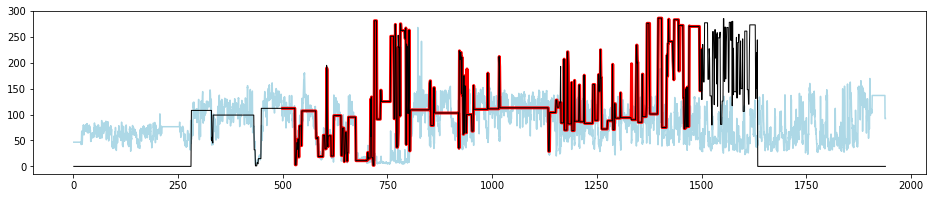

In [102]:
plt.figure(figsize=(16,3))
plt.plot(z, gr, color='lightblue')
plt.plot(gz, g, lw=3, color='red')
plt.plot(gz2, g2, lw=1, color='black')
plt.show()

## Another log to striplog

In [103]:
a = np.array([1,1,1,1,1,3,2,2,2,2,3,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,2,3,3,3,3,3,3,10,2,2,2,2,2,2,10,10,10,10,2,2,2,2,2])

In [104]:
z = np.linspace(100,200,50)

In [105]:
s = Striplog.from_log(a, legend=legend[:5], basis=z)

In [106]:
s[1]

Interval({'top': Position({'middle': 110.20408163265306, 'units': 'm'}), 'base': Position({'middle': 112.24489795918367, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'volcanic'})]})

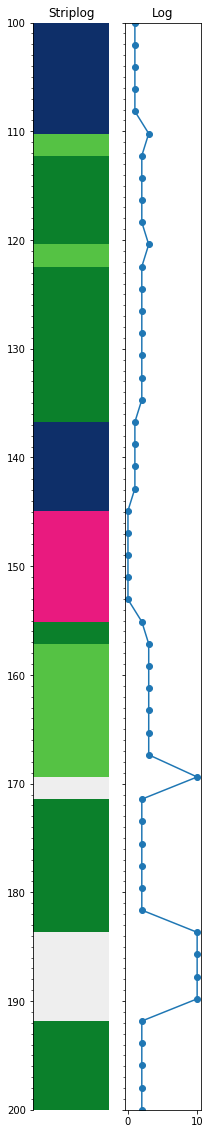

In [107]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(3,20))

# Use alpha to highlight overlaps.
ax0 = s.plot(ax=ax0)
ax1.plot(a, z, 'o-')

ax0.set_title('Striplog')
ax1.set_title('Log')

ax1.set_ylim(200, 100)

plt.show()

<hr />

## Histogram

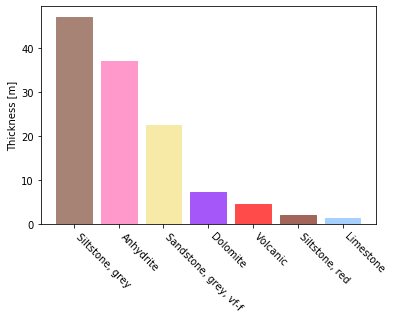

In [164]:
_ = hist(strip, legend=legend, rotation=-45, ha='left')

<hr />

## Crop a striplog

In [95]:
strip.crop((20, 100), copy=True)

Striplog(13 Intervals, start=20.0, stop=100.0)

In [96]:
strip.crop((20, 100))  # in place
strip[0]

Interval({'top': Position({'middle': 20.0, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {'porosity': array([0.15395707, 0.24965829, 0.13773359])}, 'components': [Component({'lithology': 'anhydrite'})]})

**Limitation** — right now you cannot 'crop' to an extent larger than the current striplog. Maybe we should allow that, with padding... 

In [97]:
strip.crop((0, 200))

# This should result in an error:

TypeError: list indices must be integers or slices, not NoneType

<hr />

## Graphical output formats

You should be able to natively save any format. If `matplotlib` complains, try replacing your usual import with

    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
Or in Jupyter Notebook...

    %matplotlib Agg
    
Then carry on as normal.

You need the figure object to save the striplog plot, so set `return_fig` to `True`:

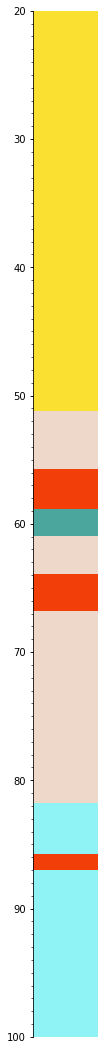

In [98]:
fig = strip.plot(return_fig=True)
fig.savefig('test.png')
fig.savefig('test.pdf')
fig.savefig('test.svg')

To find out which backend you are using:

In [99]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

<hr />

<p style="color:gray">©2015 Agile Geoscience. Licensed CC-BY. <a href="https://github.com/agile-geoscience/striplog">striplog.py</a></p>